# Saving QUIMB circuits
Created 18/09/2025

Objectives:
* Check the size of saved circuits via pickle or saving just the params.

# Package imports

In [1]:
import sys

In [2]:
sys.path.append("../../../")

In [3]:
from itertools import chain
import re

In [4]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os
import pickle

In [5]:
import numpy as np
import jax.numpy as jnp

import matplotlib.pyplot as plt

In [6]:
import quimb as qu
import quimb.tensor as qtn
from quimb.tensor.optimize import TNOptimizer

/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:54: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:36: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:73: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(


# Load data

In [7]:
DATA_DIR = r"../../../data/transverse_cluster_200_site_dmrg"

In [8]:
loaded_data = list()

for local_file_name in os.listdir(DATA_DIR):
    f_name = r"{}/{}".format(DATA_DIR, local_file_name, ignore_unknown=False)
    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)
        loaded_data.append(data)

In [9]:
b_parameters = sorted(list(d['paramters']['B'] for d in loaded_data))

In [10]:
psi_dict = dict()

In [11]:
for b in b_parameters:
    psi = next(
        d['wavefunction']
        for d in loaded_data
        if d['paramters']['B'] == b
    )

    rounded_b = round(b, 1)
    psi_dict[rounded_b] = psi

In [12]:
psi = psi_dict[0.9]

# Definitions

In [13]:
np_I = np.array([[1,0],[0,1]])
np_X = np.array([[0,1],[1,0]])

In [14]:
symmetry_actions = [
    [np_I, np_I],
    [np_I, np_X],
    [np_X, np_I],
    [np_X, np_X]
]

In [15]:
symmetry_labels = [
    'II',
    'IX',
    'XI',
    'XX'
]

In [16]:
def generate_problem_rdm(quimb_psi, symmetry_site_pairs, leftmost_symmetry_site,
                         num_symmetry_sites, num_boundary_sites):
    q_top = quimb_psi.copy(deep=True)
    for i, s in symmetry_site_pairs:
        q_top.gate(
            s,
            where=i,
            contract=False,
            inplace=True
        )

    
    indices_to_map = list(chain(
        range(leftmost_symmetry_site-num_boundary_sites, leftmost_symmetry_site),
        range(leftmost_symmetry_site+num_symmetry_sites, leftmost_symmetry_site+num_symmetry_sites+num_boundary_sites)
    ))

    index_mapping = {f'k{i}': f'b{i}' for i in indices_to_map}

    q_bottom = (
        quimb_psi
        .copy()
        .reindex(index_mapping, inplace=True)
        .conj()
    )

    sites_to_contract = {
        'left': list(range(leftmost_symmetry_site-num_boundary_sites)),
        'middle': list(range(leftmost_symmetry_site, leftmost_symmetry_site+num_symmetry_sites)),
        'right': list(range(leftmost_symmetry_site+num_symmetry_sites+num_boundary_sites, quimb_psi.L))
    }

    tags_to_contract = {
        k: [f'I{i}' for i in v]
        for k, v in sites_to_contract.items()
    }

    tn = (q_top & q_bottom)

    tnc = (
        tn
        .contract(tags_to_contract['left'])
        .contract(tags_to_contract['middle'])
        .contract(tags_to_contract['right'])
    )

    return tnc

## Optimisation functions

In [17]:
def loss(circ_pair, problem_rdm):
    c = (problem_rdm & circ_pair)^...

    c_abs_squared = (
        c
        *jnp.conjugate(c)
    )
    c_abs_squared = jnp.real(c_abs_squared)

    out = 1-c_abs_squared

    return out

## Gate functions

In [27]:
def single_qubit_layer(circ, gate_round=None):
    """Apply a parametrizable layer of single qubit ``U3`` gates.
    """
    for i in range(circ.N):
        # initialize with random parameters
        params = qu.randn(3, dist='uniform')
        circ.apply_gate(
            'U3',
            *params,
            i,
            gate_round=gate_round,
            parametrize=True
        )

In [19]:
def two_qubit_layer(circ, gate2='CZ', start=0, gate_round=None):
    """Apply a layer of constant entangling gates.
    """
    num_sites = circ.N # Assuming this is even
    sites = [
        i % num_sites
        for i in range(start, start + num_sites)
    ]
    
    site_pairs = list(zip(sites[::2], sites[1::2]))

    for i, j in site_pairs:
        circ.apply_gate(
            gate2,
            i,
            j,
            gate_round=gate_round
        )

In [73]:
def ansatz_circuit(n, depth, first_site=0, gate2='CZ',
                   gate_tag=None, **kwargs):
    """Construct a circuit of single qubit and entangling layers.
    """
    if gate_tag is None:
        circ = qtn.Circuit(n, **kwargs)
    else:
        circ = qtn.Circuit(
            n,
            gate_propagate_tags=True,
            psi0_tag=gate_tag
        )

    for r in range(depth):
        # single qubit gate layer
        single_qubit_layer(circ, gate_round=r)

        # alternate between forward and backward CZ layers
        two_qubit_layer(
            circ, gate2=gate2, gate_round=r, start=r % 2)

    # add a final single qubit layer
    single_qubit_layer(circ, gate_round=r + 1)

    circ = circ.uni
    
    if first_site != 0:
        index_labels = ['k', 'b']

        index_map = {
            f'{l}{i}': f'{l}{i+first_site}'
            for i in range(n)
            for l in index_labels
        }

        circ.reindex(index_map, inplace=True)

    return circ

In [75]:
def ansatz_circuit_pair(leftmost_symmetry_site,
    num_symmetry_sites, num_boundary_sites, depth,
    gate2='CZ', **kwargs):
    """Construct a circuit of single qubit and entangling layers.
    """
    left_start_site = leftmost_symmetry_site-num_boundary_sites
    right_start_site = leftmost_symmetry_site+num_symmetry_sites

    left_circuit = ansatz_circuit(
        num_boundary_sites,
        depth,
        first_site=left_start_site,
        gate2=gate2,
        gate_tag='left',
        **kwargs
    )

    right_circuit = ansatz_circuit(
        num_boundary_sites,
        depth,
        first_site=right_start_site,
        gate2=gate2,
        gate_tag='right',
        **kwargs
    )

    circ_pair = left_circuit & right_circuit

    return circ_pair

# Initialize problem rdm

In [22]:
num_boundary_sites=2
left_most_symmetry_site=60
num_symmetry_sites=80

total_physical_dim = 2**num_boundary_sites

In [23]:
mps_psi = psi

In [24]:
psi_arrays = list()
psi_arrays.append(mps_psi.get_B(0, 'Th')[0, ...].to_ndarray())
for i in range(1, mps_psi.L-1):
    psi_arrays.append(mps_psi.get_B(i).to_ndarray())
psi_arrays.append(mps_psi.get_B(mps_psi.L-1)[..., 0].to_ndarray())

q1 = (
    qtn
    .tensor_1d
    .MatrixProductState(psi_arrays, shape='lpr')
)

Pick this symmetry action for example.

In [25]:
k2 = 1
bs = symmetry_actions[1]

In [26]:
symmetry_site_pairs = (
    [(i, bs[0]) for i in range(left_most_symmetry_site, left_most_symmetry_site+num_symmetry_sites, 2)]
    + [(i, bs[1]) for i in range(left_most_symmetry_site+1, left_most_symmetry_site+num_symmetry_sites+1, 2)]
)

problem_rdm = generate_problem_rdm(
    q1,
    symmetry_site_pairs,
    left_most_symmetry_site,
    num_symmetry_sites,
    num_boundary_sites
)

# Generate solution

In [28]:
'COBYLA'

'COBYLA'

In [30]:
depth=2

In [76]:
circ_pair = ansatz_circuit_pair(
    left_most_symmetry_site,
    num_symmetry_sites,
    num_boundary_sites,
    depth
)

In [82]:
def split_circ_pair(circ_pair):
    left_circuit = qtn.TensorNetwork(
        list(map(circ_pair.tensor_map.__getitem__, circ_pair.tag_map['left']))
    )

    right_circuit = qtn.TensorNetwork(
        list(map(circ_pair.tensor_map.__getitem__, circ_pair.tag_map['right']))
    )

    return (left_circuit, right_circuit)

In [83]:
cl, cr = split_circ_pair(circ_pair)

In [84]:
cl

TensorNetwork(tensors=10, indices=14)

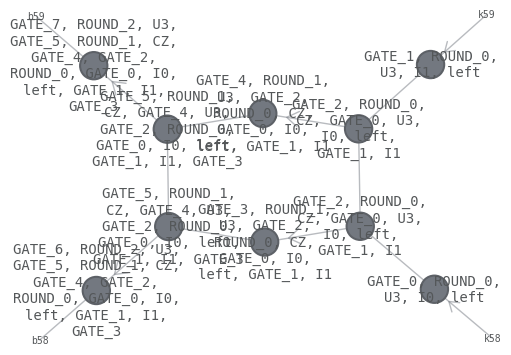

In [85]:
cl.draw()

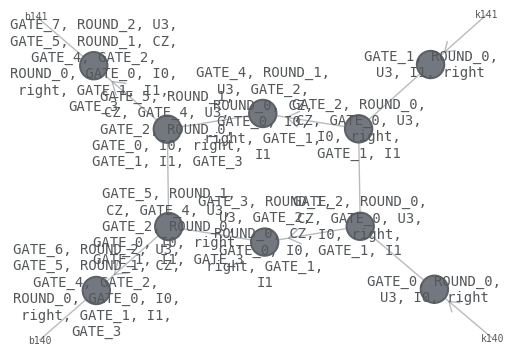

In [86]:
cr.draw()

In [87]:
cl.get_params()

{0: array([0.27863699, 0.11675102, 0.68493102]),
 1: array([0.458939  , 0.72871434, 0.58812856]),
 2: array([[[-0.34461337+0.j,  1.13818065+0.j],
         [ 0.        +0.j,  0.        +0.j]],
 
        [[ 0.        +0.j,  0.        +0.j],
         [-1.13818065+0.j, -0.34461337+0.j]]]),
 3: array([[[-1.04849371+0.j,  0.        +0.j],
         [-0.        +0.j,  0.5611368 +0.j]],
 
        [[ 0.5611368 +0.j,  0.        +0.j],
         [-0.        +0.j,  1.04849371+0.j]]]),
 4: array([0.06780288, 0.70244659, 0.60259538]),
 5: array([0.44149643, 0.10354612, 0.62485835]),
 6: array([[[-0.34461337+0.j,  1.13818065+0.j],
         [ 0.        +0.j,  0.        +0.j]],
 
        [[ 0.        +0.j,  0.        +0.j],
         [-1.13818065+0.j, -0.34461337+0.j]]]),
 7: array([[[-1.04849371+0.j,  0.        +0.j],
         [-0.        +0.j,  0.5611368 +0.j]],
 
        [[ 0.5611368 +0.j,  0.        +0.j],
         [-0.        +0.j,  1.04849371+0.j]]]),
 8: array([0.25575289, 0.82426594, 0.44184045]),

In [88]:
type(cl.get_params())

dict

In [92]:
cl.set_params(cl.get_params())
cl.get_params()

{0: array([0.27863699, 0.11675102, 0.68493102]),
 1: array([0.458939  , 0.72871434, 0.58812856]),
 2: array([[[-0.34461337+0.j,  1.13818065+0.j],
         [ 0.        +0.j,  0.        +0.j]],
 
        [[ 0.        +0.j,  0.        +0.j],
         [-1.13818065+0.j, -0.34461337+0.j]]]),
 3: array([[[-1.04849371+0.j,  0.        +0.j],
         [-0.        +0.j,  0.5611368 +0.j]],
 
        [[ 0.5611368 +0.j,  0.        +0.j],
         [-0.        +0.j,  1.04849371+0.j]]]),
 4: array([0.06780288, 0.70244659, 0.60259538]),
 5: array([0.44149643, 0.10354612, 0.62485835]),
 6: array([[[-0.34461337+0.j,  1.13818065+0.j],
         [ 0.        +0.j,  0.        +0.j]],
 
        [[ 0.        +0.j,  0.        +0.j],
         [-1.13818065+0.j, -0.34461337+0.j]]]),
 7: array([[[-1.04849371+0.j,  0.        +0.j],
         [-0.        +0.j,  0.5611368 +0.j]],
 
        [[ 0.5611368 +0.j,  0.        +0.j],
         [-0.        +0.j,  1.04849371+0.j]]]),
 8: array([0.25575289, 0.82426594, 0.44184045]),

# Conclusion
Just use `get_params` and `set_params` with pickling. Good enough.